In [5]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

home_data = pd.read_csv('housing.csv', usecols = ['longitude', 'latitude', 'median_house_value'])
home_data.head()

,longitude,latitude,median_house_value
0,-122.23,37.88,452600.0
1,-122.22,37.86,358500.0
2,-122.24,37.85,352100.0
3,-122.25,37.85,341300.0
4,-122.25,37.85,342200.0


The data include 3 variables that we have selected using the usecols parameter:

- longitude: A value representing how far west a house is. Higher values represent houses that are further West.
- latitude: A value representing how far north a house is. Higher values represent houses that are further north.
- median_house_value: The median house price within a block measured in USD. 

<Axes: xlabel='longitude', ylabel='latitude'>

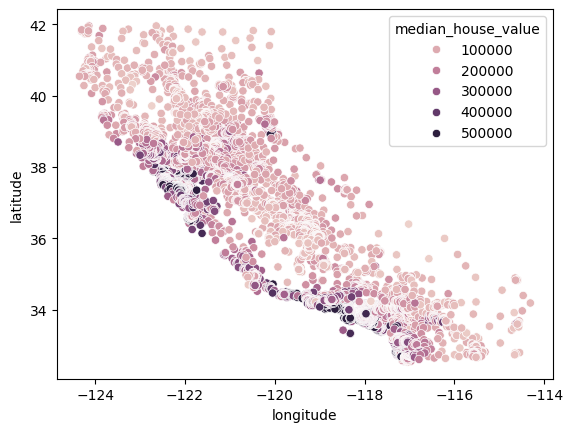

In [6]:
import seaborn as sns

sns.scatterplot(data = home_data, x = 'longitude', y = 'latitude', hue = 'median_house_value')

We see that most of the expensive houses are on the west coast of California with different areas that have clusters of moderately priced houses. This is expected as typically waterfront properties are worth more than houses that are not on the coast. 

Clusters are often easy to spot when you are only using 2 or 3 features. It becomes increasingly difficult or impossible when the

### Normalizing the Data



In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(home_data[['latitude', 'longitude']], home_data[['median_house_value']], test_size=0.33, random_state=0)

In [8]:
from sklearn import preprocessing

X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

### Training and Evaluating Model

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(X_train_norm)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,0
,copy_x,True
,algorithm,'lloyd'


Once the data are fit, we can access labels from the labels_ attribute. Below, we visualize the data we just fit. 

<Axes: xlabel='longitude', ylabel='latitude'>

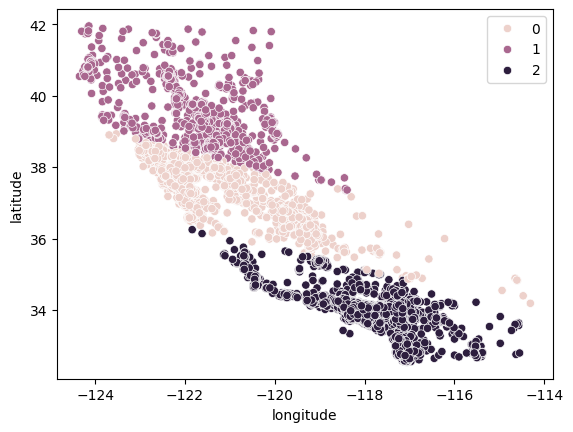

In [13]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = kmeans.labels_)

We see that the data are now clearly split into 3 distinct groups (Northern California, Central California, and Southern California). We can also look at the distribution of median house prices in these 3 groups using a boxplot. 

<Axes: ylabel='median_house_value'>

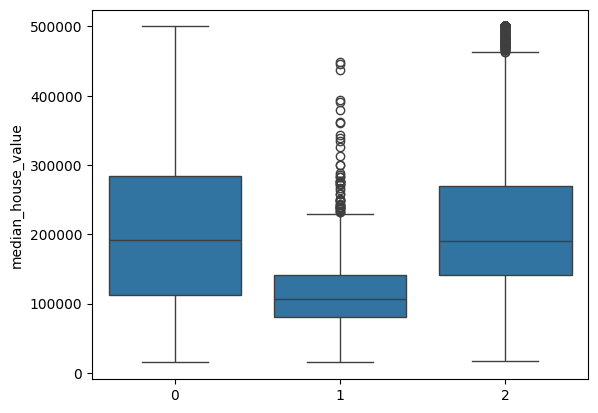

In [14]:
sns.boxplot(x = kmeans.labels_, y = y_train['median_house_value'])

We clearly see that the Northern and Southern clusters have similar distributions of median house values (clusters 0 and 2) that are higher than the prices in the central cluster (cluster 1). 

We can evaluate performance of the clustering algorithm using a Silhouette score which is a part of sklearn.metrics where a lower score represents a better fit.

In [15]:
from sklearn.metrics import silhouette_score

silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean')

0.7499371920917443

Since we have not looked at the strength of different numbers of clusters, we do not know how good of a fit the k = 3 model is. In the next section, we will explore different clusters and compare performance to make a decision on the best hyperparameter values for our model.

### Choosing the best number of clusters

The weakness of k-means clustering is that we don’t know how many clusters we need by just running the model. We need to test ranges of values and make a decision on the best value of k. We typically make a decision using the Elbow method to determine the optimal number of clusters where we are both not overfitting the data with too many clusters, and also not underfitting with too few. 

We create the below loop to test and store different model results so that we can make a decision on the best number of clusters.

In [17]:
K = range(2, 8)
fits = []
score = []


for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(X_train_norm)
    
    # append the model to fits
    fits.append(model)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(X_train_norm, model.labels_, metric='euclidean'))

We can then first visually look at a few different values of k. 

First we look at k = 2.

<Axes: xlabel='longitude', ylabel='latitude'>

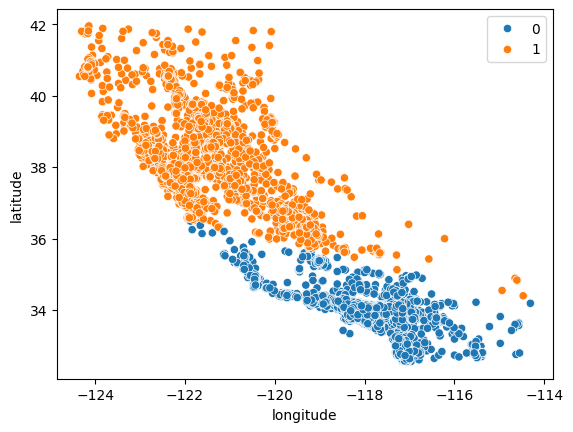

In [18]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[0].labels_)

The model does an ok job of splitting the state into two halves, but probably doesn’t capture enough nuance in the California housing market. 

Next, we look at k = 4. 



<Axes: xlabel='longitude', ylabel='latitude'>

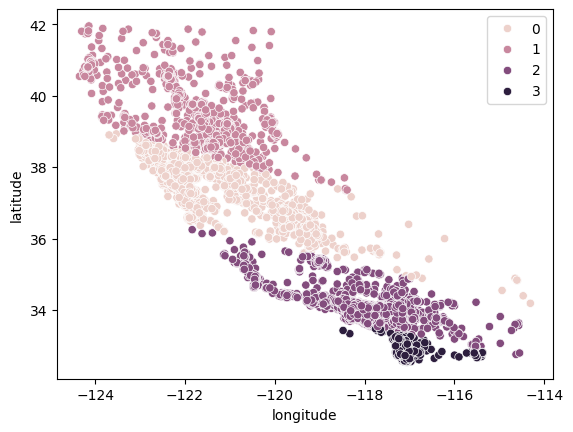

In [19]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[2].labels_)

We see this plot groups California into more logical clusters across the state based on how far North or South the houses are in the state. This model most likely captures more nuance in the housing market as we move across the state. 

Finally, we look at k = 7.

<Axes: xlabel='longitude', ylabel='latitude'>

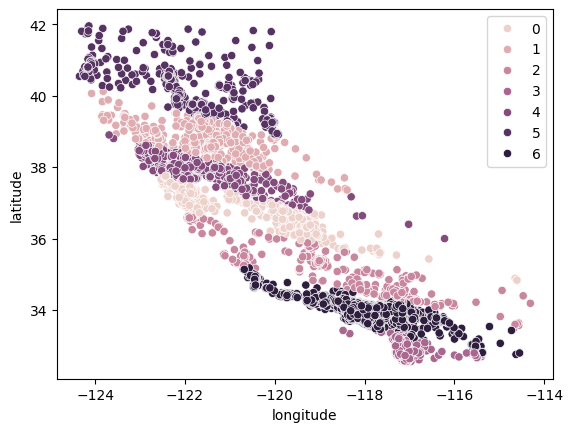

In [22]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[5].labels_)

The above graph appears to have too many clusters. We have sacrifice easy interpretation of the clusters for a “more accurate” geo-clustering result. 

Typically, as we increase the value of K, we see improvements in clusters and what they represent until a certain point. We then start to see diminishing returns or even worse performance. We can visually see this to help make a decision on the value of k by using an elbow plot where the y-axis is a measure of goodness of fit and the x-axis is the value of k. 

<Axes: >

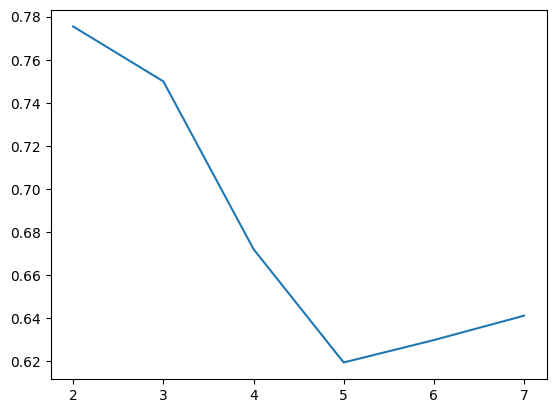

In [23]:
sns.lineplot(x = K, y = score)

We typically choose the point where the improvements in performance start to flatten or get worse. We see k = 5 is probably the best we can do without overfitting. 

We can also see that the clusters do a relatively good job of breaking California into distinct clusters and these clusters map relatively well to different price ranges as seen below.

<Axes: xlabel='longitude', ylabel='latitude'>

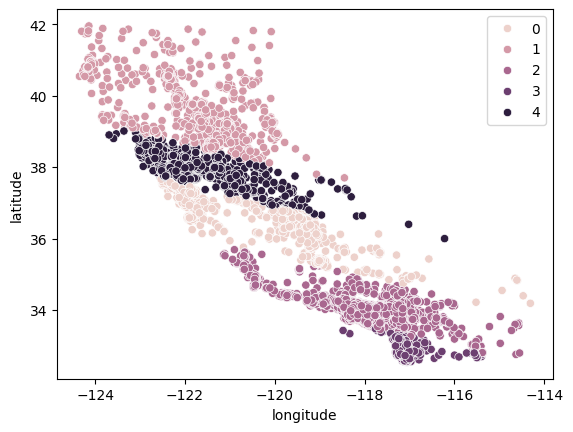

In [24]:
sns.scatterplot(data = X_train, x = 'longitude', y = 'latitude', hue = fits[3].labels_)

<Axes: ylabel='median_house_value'>

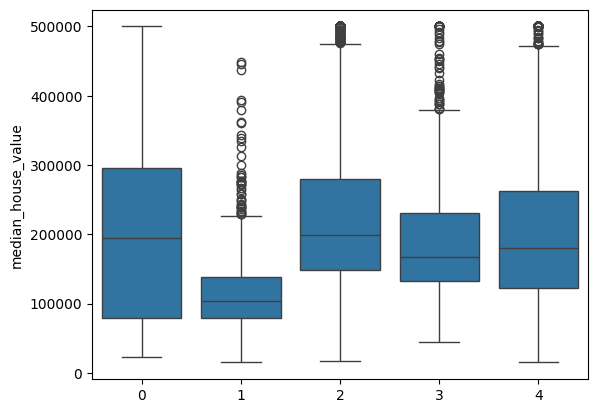

In [25]:
sns.boxplot(x = fits[3].labels_, y = y_train['median_house_value'])